# Exercise 7

1. Using the EFIplus_medit.zip dataset, check visually if any of the continuous environmental variables in the EFIplus_medit dataset (Altitude, Actual_river_slope, Elevation_mean_catch, prec_ann_catch, temp_ann, temp_jan, temp_jul) would require a data transformation in order to apply parametric tests. 

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import IsolationForest

In [15]:
df = pd.read_csv('EFIplus_medit.zip',compression='zip', sep=";")
print(df.head())

    Site_code   Latitude  Longitude Country Catchment_name  Galiza  Subsample  \
0  ES_01_0002  38.102003  -4.096070   Spain   Guadalquivir       0          1   
1  ES_02_0001  40.530188  -1.887796   Spain           Tejo       0          1   
2  ES_02_0002  40.595432  -1.928079   Spain           Tejo       0          1   
3  ES_02_0003  40.656184  -1.989831   Spain           Tejo       0          1   
4  ES_02_0004  40.676402  -2.036274   Spain           Tejo       0          1   

   Calib_EFI_Medit  Calib_connect  Calib_hydrol  ...  Squalius malacitanus  \
0                0              1             0  ...                     0   
1                1              1             1  ...                     0   
2                1              1             1  ...                     0   
3                1              1             1  ...                     0   
4                1              1             1  ...                     0   

   Squalius pyrenaicus  Squalius torgalensis

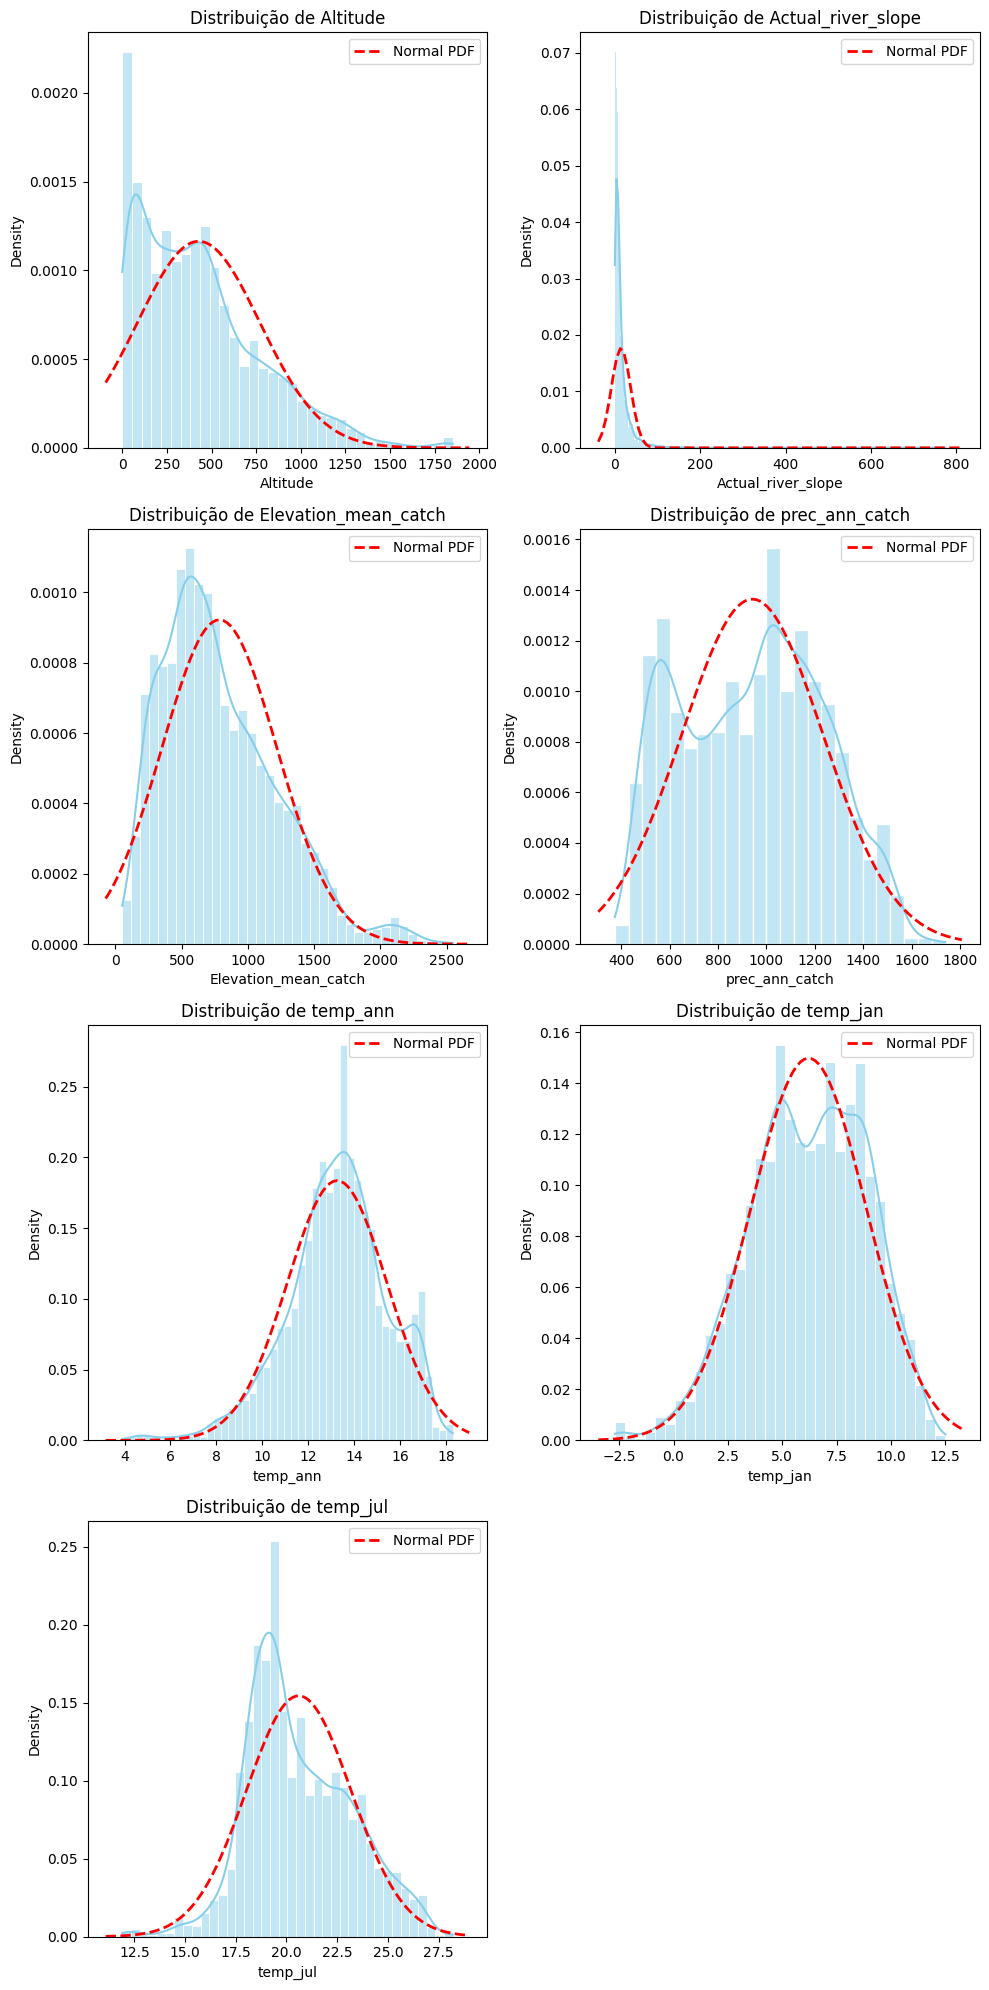

In [16]:
variables = ['Altitude', 'Actual_river_slope', 'Elevation_mean_catch',
             'prec_ann_catch', 'temp_ann', 'temp_jan', 'temp_jul']

fig, axes = plt.subplots(4, 2, figsize=(10, 20))
axes = axes.flatten()

for i, var in enumerate(variables):
    data = df[var].dropna()
    mean = data.mean()
    std = data.std()
    
    # Histogram with KDE
    sns.histplot(data, kde=True, stat='density', ax=axes[i], color='skyblue', edgecolor='white')
    
    # Normal distribution curve
    xmin, xmax = axes[i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean, std)
    axes[i].plot(x, p, 'r--', linewidth=2, label='Normal PDF')
    
    axes[i].set_title(f'Distribuição de {var}')
    axes[i].legend()

# Desativa o último gráfico se for extra
axes[-1].axis('off')

plt.tight_layout()
plt.show()

The variables Altitude, Actual_river_slope, Elevation_mean_catch and prec_ann_catch would require a data transformation in order to apply parametric tests, because their distributions are skewed and/or have heavy tails (high kurtosis) and/or have outliers.

2. Apply the appropriate data transformation and check the new distributions.

In [24]:
# Colunas a transformar
cols_to_transform = ['Altitude', 'Actual_river_slope', 'Elevation_mean_catch', 'prec_ann_catch']

# Garante que todos os valores são estritamente positivos
df_checked = df.copy()
df_checked[cols_to_transform] = df_checked[cols_to_transform].apply(
    lambda x: x + 0.001 if (x <= 0).any() else x)

# Aplicar Box-Cox
pt = PowerTransformer(method='box-cox', standardize=False)

df_transformed = df.copy()
df_transformed[cols_to_transform] = pt.fit_transform(df_checked[cols_to_transform])

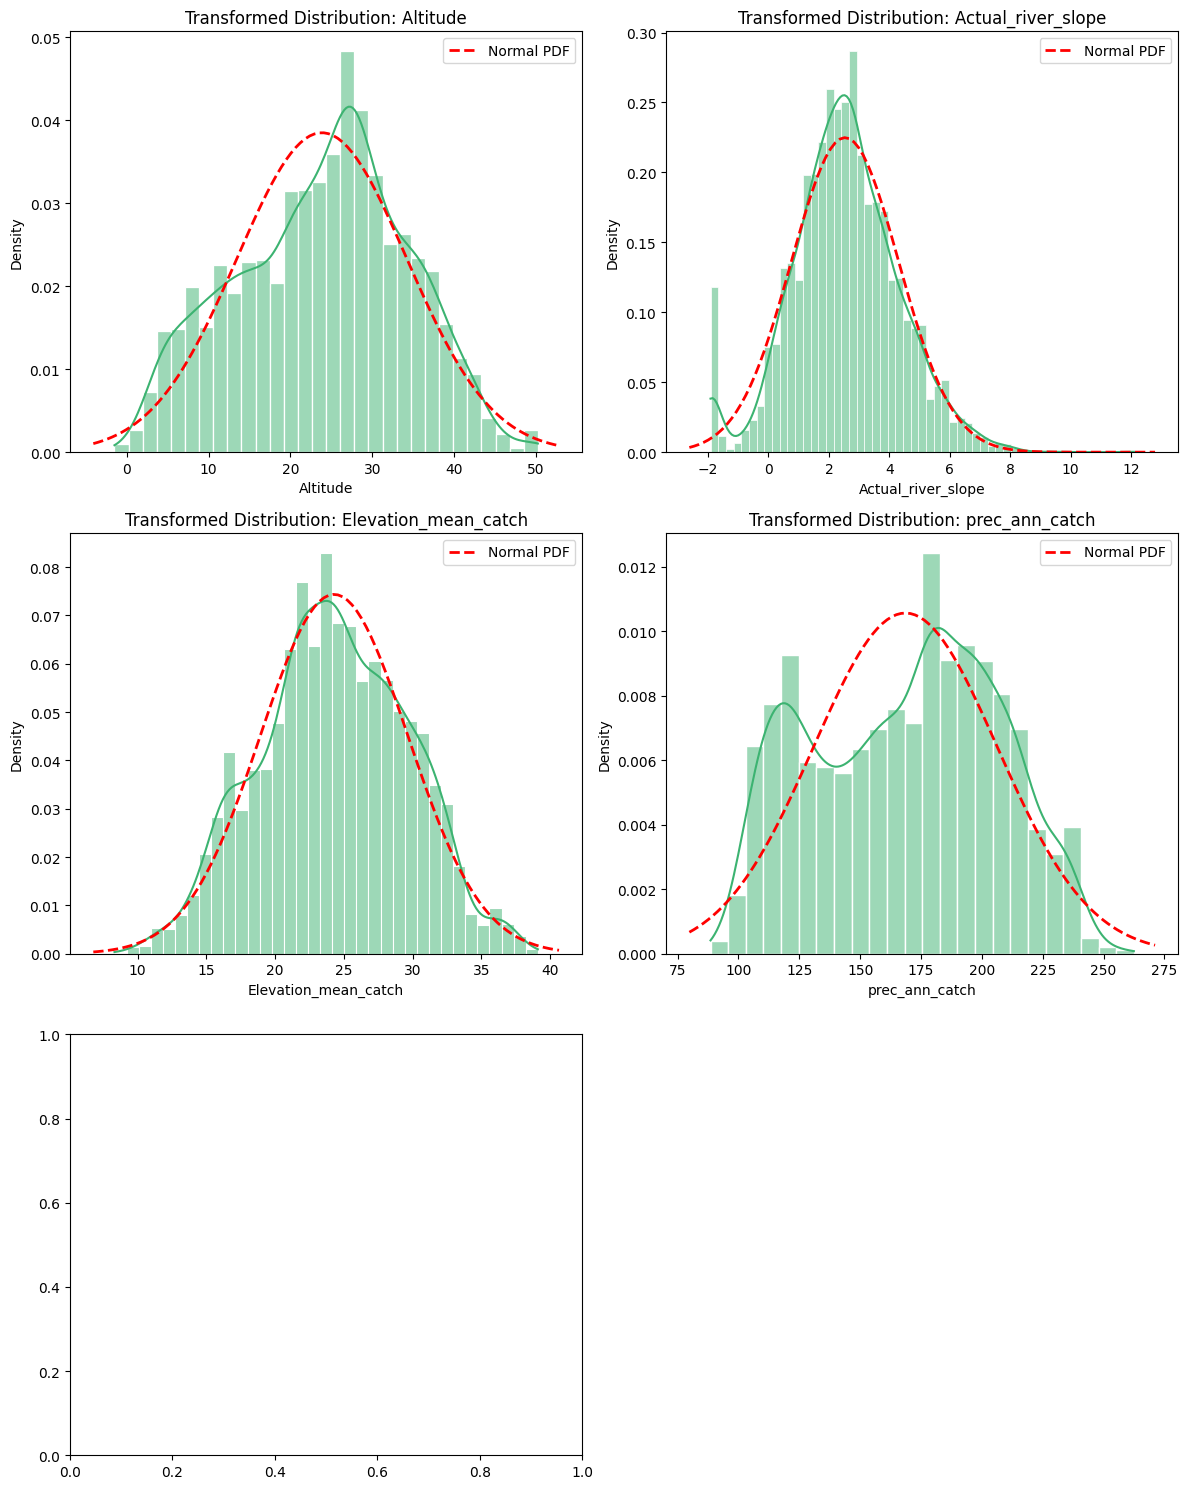

In [18]:
variables = ['Altitude', 'Actual_river_slope', 'Elevation_mean_catch',
             'prec_ann_catch']  # Ignorando temp_jan

fig, axes = plt.subplots(3, 2, figsize=(12, 15))
axes = axes.flatten()

for i, var in enumerate(variables):
    data = df_transformed[var].dropna()
    mean = data.mean()
    std = data.std()

    # Histogram with KDE
    sns.histplot(data, kde=True, stat='density', ax=axes[i], color='mediumseagreen', edgecolor='white')

    # Normal distribution curve
    xmin, xmax = axes[i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean, std)
    axes[i].plot(x, p, 'r--', linewidth=2, label='Normal PDF')

    axes[i].set_title(f'Transformed Distribution: {var}')
    axes[i].legend()

axes[-1].axis('off')

plt.tight_layout()
plt.show()

3. Create a column with the total number of species present (the species richness) in each sampling site (NOTE: the first species in the dataset is ‘Abramis brama’ and all the columns to the right correspond to species presence/absence).

In [19]:
species_columns = df.columns[56:]  

# Criando a coluna de riqueza de espécies (contagem de espécies presentes)
df['species_richness'] = df[species_columns].sum(axis=1)

# Exibe as primeiras linhas para verificar
print(df[['Site_code', 'species_richness']].head())

    Site_code  species_richness
0  ES_01_0002                 1
1  ES_02_0001                 1
2  ES_02_0002                 1
3  ES_02_0003                 2
4  ES_02_0004                 2


4. Check the existence of bivariate outliers in the relationship between Mean Annual Temperature (‘temp_ann’) and species richness using an appropriate plot. Run a bivariate isolation forest to detect outliers and plot the result.

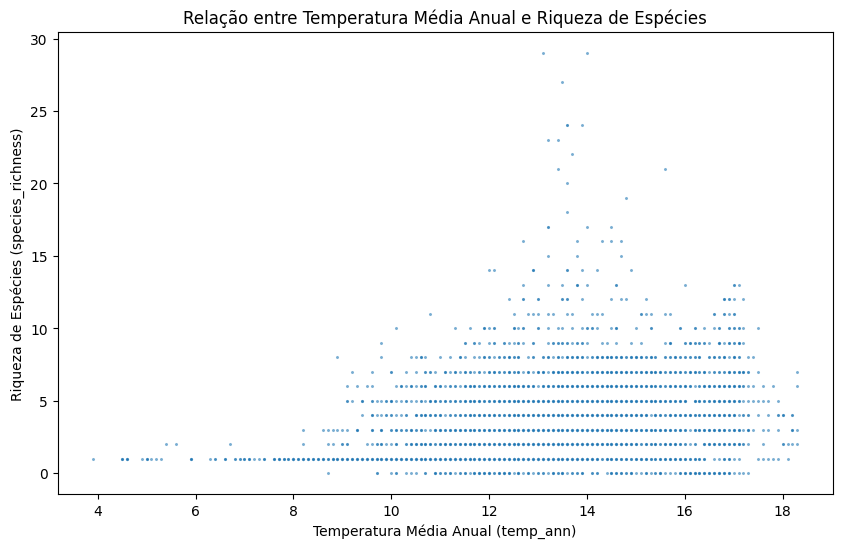

In [20]:
# Plot de dispersão entre 'temp_ann' e 'species_richness'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='temp_ann', y='species_richness', s=5, alpha=0.6)
plt.title('Relação entre Temperatura Média Anual e Riqueza de Espécies')
plt.xlabel('Temperatura Média Anual (temp_ann)')
plt.ylabel('Riqueza de Espécies (species_richness)')
plt.show()

In [21]:
# Selecionando as colunas relevantes
X = df[['temp_ann', 'species_richness']]

# Criar o modelo de Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Ajuste a contaminação conforme necessário

# Ajustar o modelo aos dados
outliers = iso_forest.fit_predict(X)

# O resultado de fit_predict é -1 para outliers e 1 para inliers
df['outlier'] = outliers


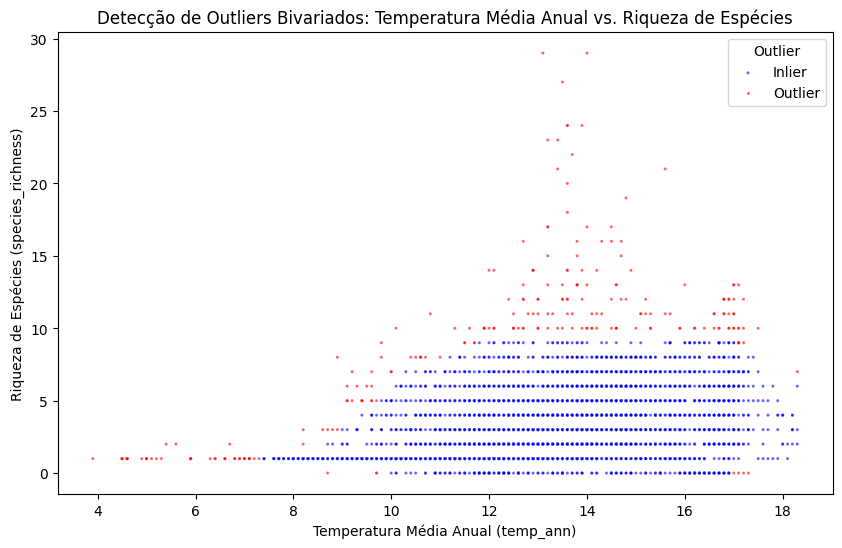

In [22]:
# Plotando o gráfico com os outliers marcados
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='temp_ann', y='species_richness', hue='outlier', palette={1: 'blue', -1: 'red'}, s=5, alpha=0.6)
plt.title('Detecção de Outliers Bivariados: Temperatura Média Anual vs. Riqueza de Espécies')
plt.xlabel('Temperatura Média Anual (temp_ann)')
plt.ylabel('Riqueza de Espécies (species_richness)')
plt.legend(title='Outlier', labels=['Inlier', 'Outlier'])
plt.show()

5. Explore visually, using a single plot, if this relationship (temp_ann x species richness) may vary across countries

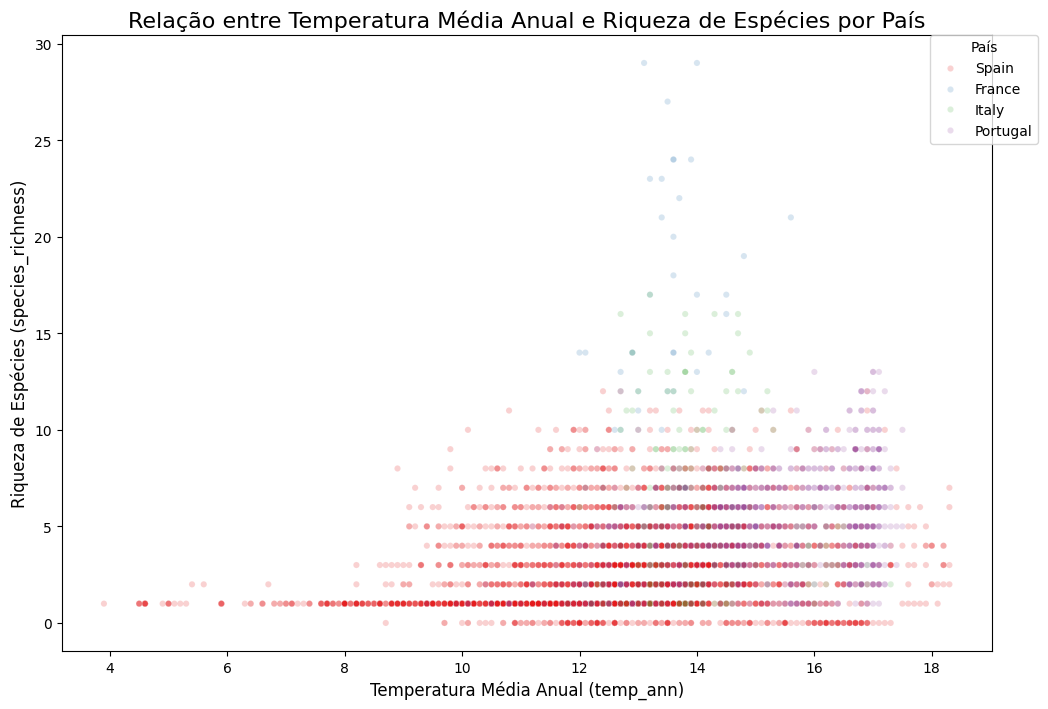

In [23]:
plt.figure(figsize=(12, 8))

# Gráfico de dispersão com diferentes cores para os países
sns.scatterplot(data=df, x='temp_ann', y='species_richness', hue='Country', palette='Set1', s=20, alpha=0.2)

# Título e rótulos
plt.title('Relação entre Temperatura Média Anual e Riqueza de Espécies por País', fontsize=16)
plt.xlabel('Temperatura Média Anual (temp_ann)', fontsize=12)
plt.ylabel('Riqueza de Espécies (species_richness)', fontsize=12)

# Exibir a legenda
plt.legend(title='País', loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.show()